In [1]:
# Advance Lane Finding

In [2]:
#1.-Camera Calibartion

In [3]:
from moviepy.editor import VideoFileClip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os
%matplotlib inline

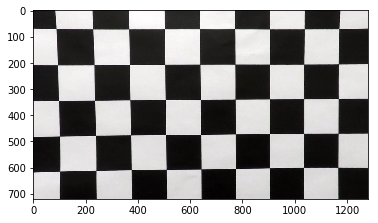

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
object_points = [] #real points 3D
image_points = [] #point of the different images 2D

obj_points = np.zeros((6*9,3), np.float32)
obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
total = 0
for image in images:
    
    #read each image
    img = mpimg.imread(image) 

    #convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #find corner for the cheesboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(obj_points)

#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)

#test the calibration a plot image1
test_image = mpimg.imread('camera_cal/calibration1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
plt.imshow(dst)



In [ ]:
test_image = mpimg.imread('test_images/straight_lines1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


In [ ]:
#2.- COLOR TRANSFORM, GRADIENTS FOR BINARY IMAGE

In [ ]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def get_binary_filtered_img(path,mtx, dist, saturation_thresh=(170, 255), sobel_thresh=(20, 100), light_thresh=(0,80)):
    
    #reading in an image
    if type(path) == type("String"):
        img = mpimg.imread(path)
    else:
        img = path
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply the following steps to img
    # Convert to hls color space
    hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    
    #calculating sobel for X
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel_x = np.absolute(sobel_x)
    
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[(s_channel >= saturation_thresh[0]) & (s_channel <= saturation_thresh[1])] = 1
    
    light_binary = np.zeros_like(l_channel)
    light_binary[(l_channel >= light_thresh[0]) & (l_channel <= light_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, sobel_binary)) * 255
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[((sobel_binary == 1) & (light_binary == 1))|((sobel_binary == 1) &(saturation_binary == 1))] = 1
    combined_binary_1 = np.zeros_like(sobel_binary)
    combined_binary_1[((saturation_binary == 1) | (sobel_binary == 1)) & (light_binary == 1)] = 1
    # 6) Return this mask as your binary_output image
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(2, 2, 1)
    plt.imshow(img)
    fig.add_subplot(2, 2, 2)
    plt.imshow(combined_binary, cmap= 'gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(combined_binary_1, cmap= 'gray')
    fig.add_subplot(2, 2, 4)
    plt.imshow((combined_binary - combined_binary_1), cmap= 'gray')'''
    
    
    return combined_binary, undist_image

binary_images = {}
undistorted_images = {}

list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    f_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    binary_images["binary_"+file] = f_binary_image
    undistorted_images ["undist_"+file] = undist_image
    

#plt.imshow(grad_binary, cmap='gray')

In [ ]:
#3.-PERSPECTIVE TRANSFORM

In [ ]:
def prespective_transform(img, source_point, destination_point):
    
    #transforming binary image to 3d image for drawing color lines
    img_with_lines_s = np.dstack(( img, img, img))* 255
    
    #parameters for color lines
    color=[255, 0, 0]
    thickness=4
    
    
    #Drawings color lines for source
    cv2.line(img_with_lines_s, (source_point[0,0], source_point[0,1]), (source_point[1,0], source_point[1,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[1,0], source_point[1,1]), (source_point[2,0], source_point[2,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[2,0], source_point[2,1]), (source_point[3,0], source_point[3,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[3,0], source_point[3,1]), (source_point[0,0], source_point[0,1]), color, thickness)
    
    
    img_size = (img.shape[1],img.shape[0])
    Warped_matrix = cv2.getPerspectiveTransform(source_point,destination_point)
    image_warpe = cv2.warpPerspective(img, Warped_matrix, img_size)
    
    #transforming binary image to 3d image for drawing color lines
    image_warpe_with_lines = np.dstack(( image_warpe, image_warpe, image_warpe))* 255
    
    #Drawings color lines for destination
    cv2.line(image_warpe_with_lines, (destination_point[0,0], destination_point[0,1]), (destination_point[1,0], destination_point[1,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[1,0], destination_point[1,1]), (destination_point[2,0], destination_point[2,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[2,0], destination_point[2,1]), (destination_point[3,0], destination_point[3,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[3,0], destination_point[3,1]), (destination_point[0,0], destination_point[0,1]), color, thickness)
    
    #print figures
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_with_lines_s, cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(image_warpe_with_lines, cmap='gray')'''
    #plt.show()
    
    return image_warpe

#Source points
x1_s = 200
x2_s = 555
x3_s = 732
x4_s = 1100
y_top_s = 720
y_low_s = 480
#generating the array for source points
src = np.float32([[x1_s, y_top_s],[x2_s, y_low_s],[x3_s, y_low_s],[x4_s, y_top_s]])

#destination points
x_low_d = 290
x_top_d = 990
y_top_d = 720
y_low_d = 0
#generating the array for destination points
dst = np.float32([[x_low_d, y_top_d],[x_low_d, y_low_d],[x_top_d, y_low_d],[x_top_d, y_top_d]])

prespective_images = {}
fig = plt.figure(figsize=(100, 100))
for key, image in binary_images.items() :
    print (key)
    f_prespective_image = prespective_transform(image,src,dst)
    prespective_images["presp_"+key] = f_prespective_image
    

binary_test3.jpg
binary_test4.jpg
binary_straight_lines1.jpg
binary_test2.jpg
binary_straight_lines2.jpg
binary_test1.jpg
binary_test5.jpg
binary_test6.jpg


<Figure size 7200x7200 with 0 Axes>

In [ ]:
#4.- SLIDING WINDOW DRAWING RECTANGLES

presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_straight_lines1.jpg
presp_binary_test2.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


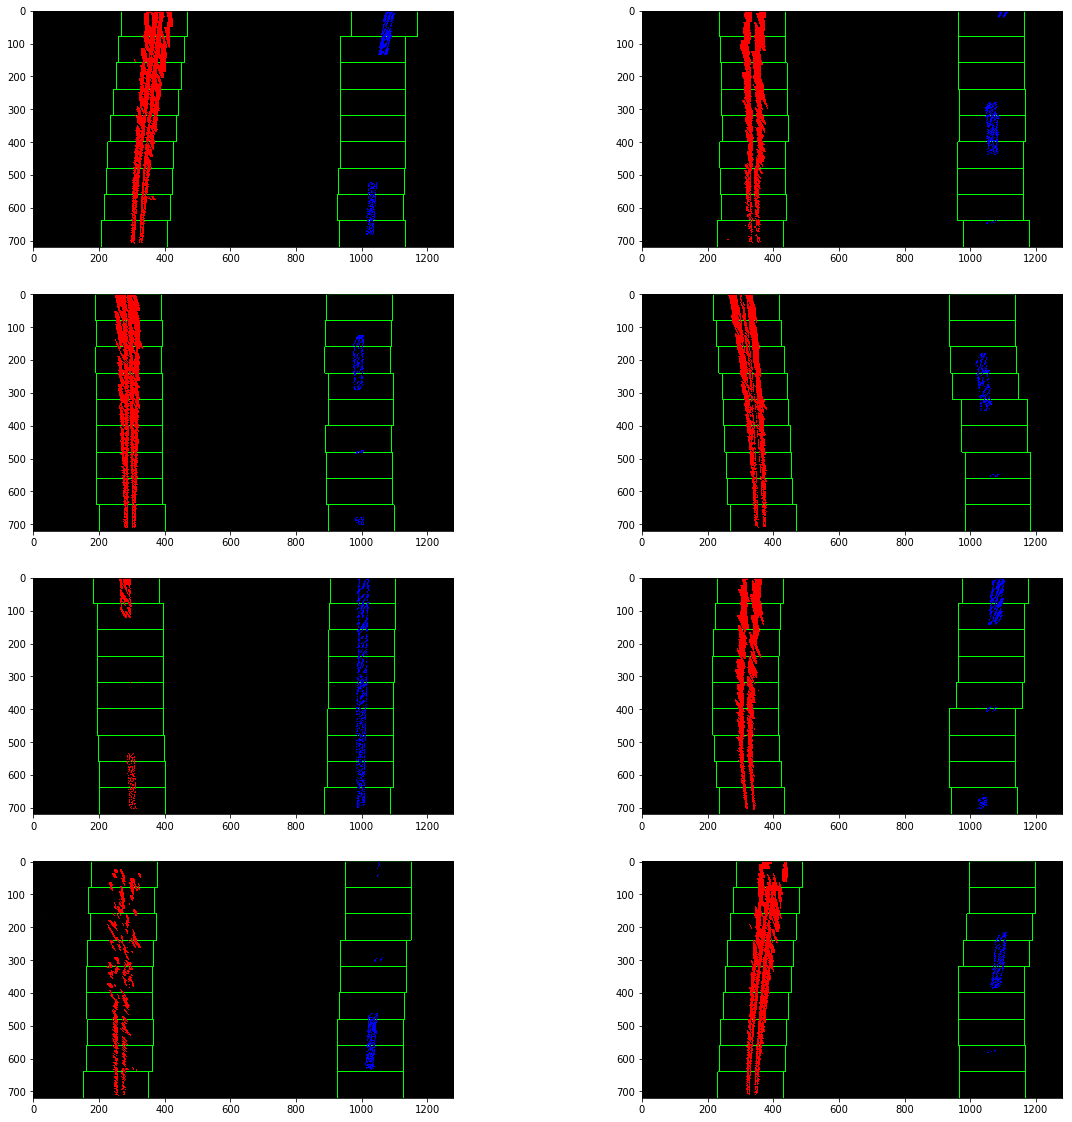

In [ ]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &( nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return binary_warped, out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

poly_fit_images = {}
fig = plt.figure(figsize=(20, 20))
count = 1
for key, image in prespective_images.items() :
    print (key)
    fig.add_subplot(4, 2, count)
    poly_fit_images[key] = fit_polynomial(image)
    plt.imshow(poly_fit_images[key][1])
    count += 1

    

In [ ]:
#5.- SEARCH FROM PREVIOUS POLYFIT RESULT AND CURVATURE CALCULATION

presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_straight_lines1.jpg
presp_binary_test2.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


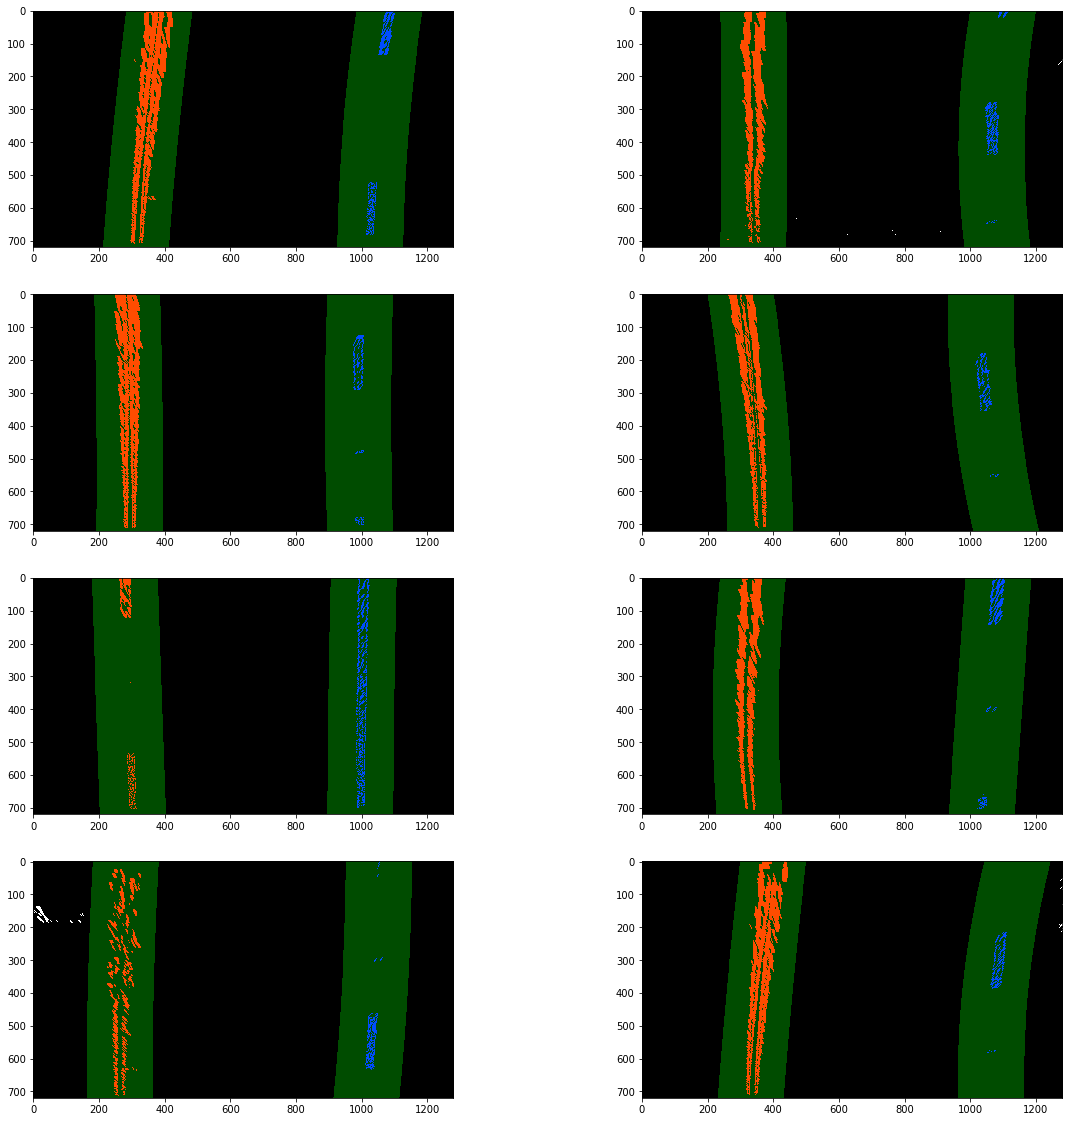

In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Calculation the Curvature
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    try:
        left_fit_m = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_m = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    except TypeError:
        left_fit_m = np.array([0,0,0])
        right_fit_m = np.array([0,0,0])
        pass
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image in m
    y_eval_m = y_eval * ym_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) from f(y) = Ay^2 + By + C  f'(y) = 2Ay + B  f''(y) = 2A#####
    #Rcurve = ([1+ (dx/dy)^2]^(3/2))/(|(d2x/dy2)|) = ([1+ (2Ay + B)^2]^(3/2))/(|2A|)
    left_curve_rad = np.power((1+np.power(2*left_fit[0]*y_eval+left_fit[1],2)),(3/2))/np.absolute(2*left_fit[0]) 
    right_curve_rad = np.power((1+np.power(2*right_fit[0]*y_eval+right_fit[1],2)),(3/2))/np.absolute(2*right_fit[0])   
    #print(left_curve_rad, right_curve_rad)
    
    ### Real world calculation
    left_curve_rad_m = np.power((1+np.power(2*left_fit_m[0]*y_eval_m*+left_fit_m[1],2)),(3/2))/np.absolute(2*left_fit_m[0])  
    right_curve_rad_m = np.power((1+np.power(2*right_fit_m[0]*y_eval_m+right_fit_m[1],2)),(3/2))/np.absolute(2*right_fit_m[0])   
    #print(left_curve_rad_m, 'm', right_curve_rad_m, 'm')
    
    
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curve_rad_m, right_curve_rad_m

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values ###

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_new, right_fit_new, left_curve_rad_m, right_curve_rad_m = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, left_fit_new, right_fit_new, left_curve_rad_m, right_curve_rad_m

#DU -Don't use it
search_around_poly_out = {}
fig = plt.figure(figsize=(20, 20))
count = 1
#poly_fit_images_items tuple contains binary_warped, out_img, left_fit, right_fit
for key, poly_fit_images_items in poly_fit_images.items() :
    print(key)
    fig.add_subplot(4, 2, count)
    search_around_poly_out[key] = search_around_poly(poly_fit_images_items[0],poly_fit_images_items[2],poly_fit_images_items[3])
    plt.imshow(search_around_poly_out[key][0])
    count += 1
    


In [ ]:
#6.- DRAWING LINES REGION IN UNDISTORTED COLOR IMAGE

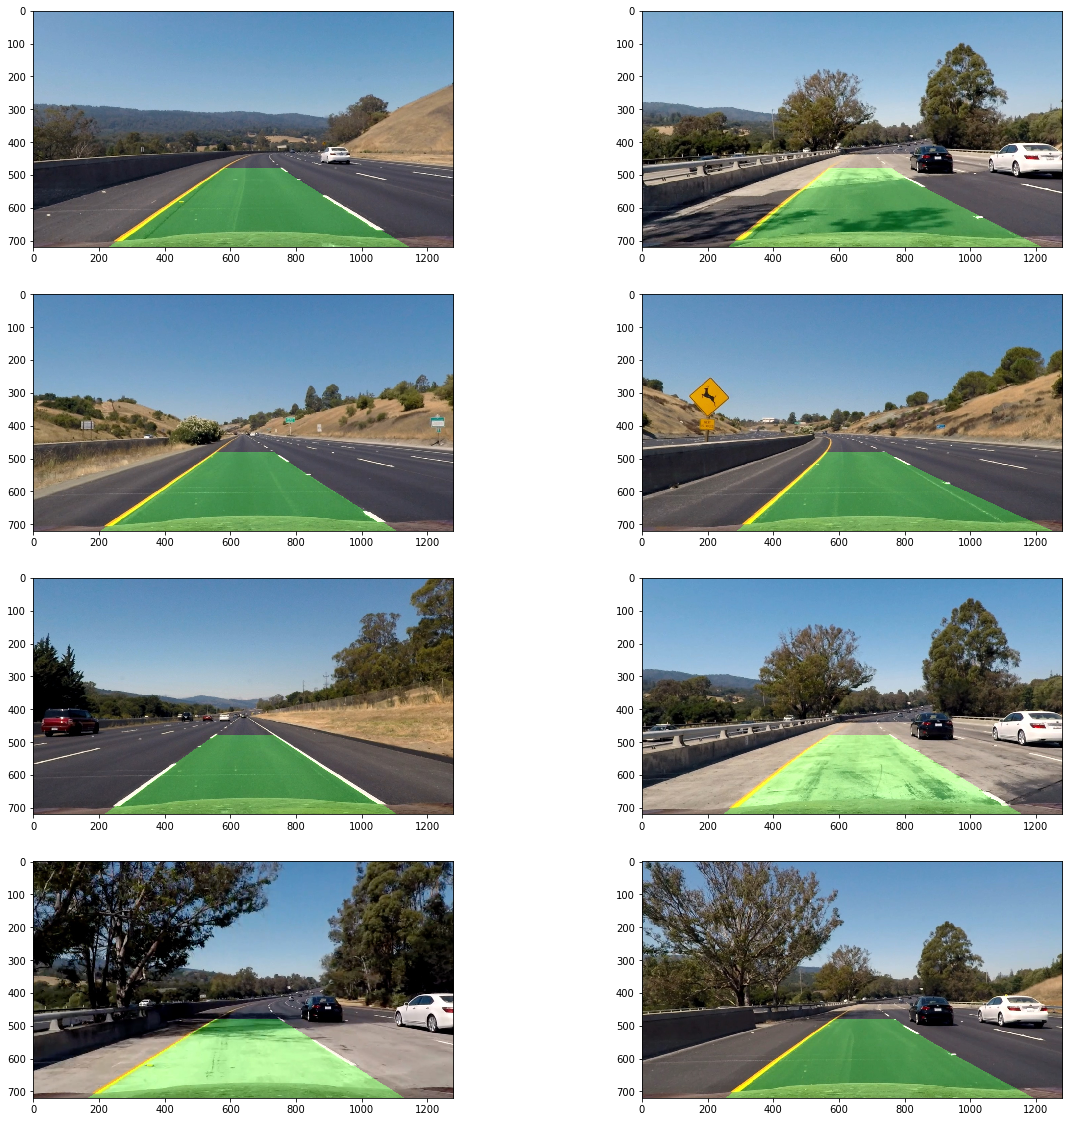

In [ ]:
def draw_lines_region(undist_image, warped, left_fitx, right_fitx, ploty,source_points,destinaton_points):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Calcultaing unwarped matrix 
    Inv_Warped_matrix = cv2.getPerspectiveTransform(source_points,destinaton_points)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Inv_Warped_matrix, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_region_lines = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return image_region_lines

fig = plt.figure(figsize=(20, 20))
count = 1
for file in list_images:
    fig.add_subplot(4, 2, count)
    image_full_region_lines = draw_lines_region(undistorted_images['undist_'+file], poly_fit_images['presp_binary_'+file][0], search_around_poly_out['presp_binary_'+file][1], search_around_poly_out['presp_binary_'+file][2], search_around_poly_out['presp_binary_'+file][3],dst,src)
    cool_image = image_full_region_lines
    plt.imshow(cool_image)
    count += 1

In [ ]:
#7 CALIING ALL PREVIOUS FUNCTIONS#

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([False])] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the last n fits
        self.n_fits = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #counts the number of the first n loops 
        self.loops_counter = 0
        #counts the number of error of calculation
        self.error_fit = 0

#Calculate average of left and right coeficients
def average_coeficients(left_line_n_fits, right_line_n_fits):
    left_line.best_fit = [np.array([0,0,0])] 
    right_line.best_fit = [np.array([0,0,0])] 
    
    for i in range(left_line_n_fits.shape[0]): 
        left_line.best_fit += left_line_n_fits[i]
    left_line.best_fit = left_line.best_fit / left_line_n_fits.shape[0]
    
    for i in range(right_line_n_fits.shape[0]): 
        right_line.best_fit += right_line_n_fits[i]
    right_line.best_fit = right_line.best_fit / right_line_n_fits.shape[0]


#check if the lines are parallel base on the distance between the top, middle and low points on x axis of the 2 lines
        
def line_distance_comparison(left_fitx, right_fitx):
    
    #distance between lines in pixels 
    dist_btween_lines = 700
    
    #treshhold of parallel lines between x and y
    between_lines_threshhold = 50
    
    if ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1]) < (dist_btween_lines + between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)//2]-left_fitx[len(left_fitx)//2]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)//2]-left_fitx[len(left_fitx)//2]) < (dist_btween_lines + between_lines_threshhold)) &\
    ((right_fitx[0]-left_fitx[0]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[0]-left_fitx[0]) < (dist_btween_lines + between_lines_threshhold)):
        return True
    else:
        return False
        
def main_call(path_image):

    #define de number of n loops
    n_loops = 10
    
    #treshhold of parallel lines between same line x or
    between_same_lines_threshhold = 15
    
    #thershhold for continues bad calculation of a line fit
    bad_calc_line_threshhold = 10
    
    #Undistort the image and get binary image
    #saturation_thresh=(15, 150), sobel_thresh=(5, 50), light_thresh=(50,255)) #chanllenge video #white lines light_thresh=(200,240)
    #saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255)) #ptoject video
    final_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(110, 200), sobel_thresh=(1, 50), light_thresh=(200,240)) #chanllenge video
    #generat 3d binary image just for testing
    final_binary_image_3d_format = np.dstack((final_binary_image, final_binary_image, final_binary_image))*255
    
    #Use perspective trasform for eagle view
    final_prespective_image = prespective_transform(final_binary_image,src,dst)
    
    
    if (left_line.detected == False  & right_line.detected == False) :
        #return polyfit for left and right line
        binary_warped, out_img, left_line.current_fit, right_line.current_fit, left_fitx, right_fitx, ploty = fit_polynomial(final_prespective_image)
        left_line.detected = right_line.detected = True
        print_test_image = out_img

    else:
        #draw line band base on polyfit
        result_image_band_line, left_fitx, right_fitx, ploty, left_line.current_fit, right_line.current_fit, \
        left_curve_rad_m, right_curve_rad_m = search_around_poly(final_prespective_image, left_line.current_fit, \
        right_line.current_fit)
        left_line.radius_of_curvature = left_curve_rad_m
        right_line.radius_of_curvature = right_curve_rad_m
        print_test_image = result_image_band_line
    

    
    #Compare the distance in three point bottom, middle and top in Y axis and decide if the they meet the treshholds
    if  left_line.loops_counter == 0 & right_line.loops_counter == 0 :
        left_line.n_fits = np.array([left_line.current_fit])
        right_line.n_fits = np.array([right_line.current_fit])
        left_line.loops_counter += 1
        right_line.loops_counter += 1
        
        
    elif ((left_line.loops_counter < n_loops) & (right_line.loops_counter < n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            left_line.loops_counter += 1
            right_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.loops_counter += 1
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.loops_counter += 1
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
        
 

    elif ((left_line.loops_counter == n_loops) & (right_line.loops_counter < n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            right_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.loops_counter += 1
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            
    elif ((left_line.loops_counter < n_loops) & (right_line.loops_counter == n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            left_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.loops_counter += 1
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)


    else:
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
    #calculate the average of the coeficients
    average_coeficients(left_line.n_fits, right_line.n_fits)
            
    if (left_line.error_fit >= bad_calc_line_threshhold) | (right_line.error_fit >= bad_calc_line_threshhold) :
        left_line.detected = right_line.detected = False
        print("Recalculating square fitting")
            
    #Check which line or line is not calculated correctly and choose the correct coeficient (Ax^2 + Bx + C) used in this loop to plot the image
    
    #If the coeficients are good store them and calculate the average, if not increment count of faluty and use stored average, if the counter is equal to 3 call fit_polynomial function to calculate squares
    
    #Calculate the offset to the center line
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_between_lines = ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1])/2)+left_fitx[len(left_fitx)-1]
    Offset_center_lines = final_binary_image.shape[1]/2 - center_between_lines
    left_line.line_base_pos = right_line.line_base_pos = Offset_center_lines*xm_per_pix

    #draw region in green for undistorted image
    f_image_region_lines = draw_lines_region(undist_image, final_prespective_image, left_fitx, right_fitx, ploty,dst,src)
    
    
    #writing the lines curvature from each line as text in the image
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    leftLineTextPosition = (10,20)
    rightLineTextPosition = (10,50)
    offcetToCenterPosition = (10,80)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(f_image_region_lines,'Curvature left line: '+str(np.round(left_line.radius_of_curvature,2))+ ' m', 
    leftLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Curvature right line: '+str(np.round(right_line.radius_of_curvature,2))+ ' m', 
    rightLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Offset to center: '+str(np.round(left_line.line_base_pos,2))+ ' m', 
    offcetToCenterPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    return f_image_region_lines #image_region_lines

left_line = Line()
right_line = Line()

'''
fig = plt.figure(figsize=(20, 20))
count = 1
list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    main_call(path_image)
    print_image = main_call(path_image)
    fig.add_subplot(4, 2, count)
    plt.imshow(print_image)
    count += 1'''
    

input_video = "challenge_video.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(main_call)
white_clip.write_videofile("output_images/"+input_video)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing audio in challenge_videoTEMP_MPY_wvf_snd.mp3


100%|██████████| 357/357 [00:00<00:00, 1634.29it/s]

[MoviePy] Done.
[MoviePy] Writing video output_images/challenge_video.mp4



  3%|▎         | 13/485 [00:01<00:44, 10.49it/s]

Recalculating square fitting
Recalculating square fitting
Recalculating square fitting


  4%|▎         | 17/485 [00:01<00:48,  9.68it/s]

Recalculating square fitting
Recalculating square fitting


  4%|▍         | 19/485 [00:01<00:53,  8.69it/s]

Recalculating square fitting
Recalculating square fitting


  4%|▍         | 20/485 [00:02<00:56,  8.17it/s]

Recalculating square fitting


  5%|▍         | 22/485 [00:02<01:13,  6.32it/s]

Recalculating square fitting
Recalculating square fitting


  5%|▍         | 24/485 [00:02<01:07,  6.80it/s]

Recalculating square fitting


  6%|▌         | 27/485 [00:03<00:59,  7.65it/s]

Recalculating square fitting
Recalculating square fitting


  6%|▌         | 29/485 [00:03<01:00,  7.55it/s]

Recalculating square fitting
Recalculating square fitting


  6%|▋         | 31/485 [00:03<00:59,  7.65it/s]

Recalculating square fitting
Recalculating square fitting


  7%|▋         | 33/485 [00:03<00:57,  7.81it/s]

Recalculating square fitting
Recalculating square fitting


  7%|▋         | 35/485 [00:04<00:55,  8.09it/s]

Recalculating square fitting
Recalculating square fitting


  8%|▊         | 37/485 [00:04<00:54,  8.21it/s]

Recalculating square fitting
Recalculating square fitting


  8%|▊         | 39/485 [00:04<00:53,  8.41it/s]

Recalculating square fitting
Recalculating square fitting


  8%|▊         | 41/485 [00:04<00:52,  8.40it/s]

Recalculating square fitting
Recalculating square fitting


  9%|▉         | 43/485 [00:05<00:59,  7.47it/s]

Recalculating square fitting
Recalculating square fitting


  9%|▉         | 45/485 [00:05<01:02,  7.06it/s]

Recalculating square fitting
Recalculating square fitting


 10%|▉         | 47/485 [00:05<00:57,  7.57it/s]

Recalculating square fitting
Recalculating square fitting


 10%|█         | 49/485 [00:05<01:00,  7.20it/s]

Recalculating square fitting
Recalculating square fitting


 11%|█         | 51/485 [00:06<00:58,  7.41it/s]

Recalculating square fitting
Recalculating square fitting


 11%|█         | 53/485 [00:06<00:59,  7.29it/s]

Recalculating square fitting
Recalculating square fitting


 11%|█▏        | 55/485 [00:06<01:01,  7.05it/s]

Recalculating square fitting
Recalculating square fitting


 12%|█▏        | 57/485 [00:07<01:02,  6.81it/s]

Recalculating square fitting
Recalculating square fitting


 12%|█▏        | 59/485 [00:07<01:03,  6.72it/s]

Recalculating square fitting
Recalculating square fitting


 13%|█▎        | 61/485 [00:07<00:58,  7.25it/s]

Recalculating square fitting
Recalculating square fitting


 13%|█▎        | 63/485 [00:07<00:55,  7.61it/s]

Recalculating square fitting
Recalculating square fitting


 13%|█▎        | 65/485 [00:08<00:53,  7.89it/s]

Recalculating square fitting
Recalculating square fitting


 14%|█▍        | 67/485 [00:08<00:52,  7.92it/s]

Recalculating square fitting
Recalculating square fitting


 14%|█▍        | 69/485 [00:08<00:48,  8.54it/s]

Recalculating square fitting
Recalculating square fitting


 15%|█▍        | 71/485 [00:08<00:53,  7.79it/s]

Recalculating square fitting
Recalculating square fitting


 15%|█▌        | 73/485 [00:09<00:48,  8.43it/s]

Recalculating square fitting
Recalculating square fitting


 15%|█▌        | 75/485 [00:09<00:51,  8.00it/s]

Recalculating square fitting
Recalculating square fitting


 16%|█▌        | 77/485 [00:09<00:48,  8.45it/s]

Recalculating square fitting
Recalculating square fitting


 16%|█▋        | 79/485 [00:09<00:48,  8.38it/s]

Recalculating square fitting
Recalculating square fitting


 17%|█▋        | 81/485 [00:10<00:48,  8.32it/s]

Recalculating square fitting
Recalculating square fitting


 17%|█▋        | 83/485 [00:10<00:45,  8.77it/s]

Recalculating square fitting
Recalculating square fitting


 18%|█▊        | 85/485 [00:10<00:49,  8.14it/s]

Recalculating square fitting
Recalculating square fitting


 18%|█▊        | 87/485 [00:10<00:50,  7.85it/s]

Recalculating square fitting
Recalculating square fitting


 18%|█▊        | 89/485 [00:11<00:48,  8.16it/s]

Recalculating square fitting
Recalculating square fitting


 19%|█▊        | 90/485 [00:11<00:46,  8.46it/s]

Recalculating square fitting
Recalculating square fitting


 19%|█▉        | 93/485 [00:11<00:48,  8.10it/s]

Recalculating square fitting
Recalculating square fitting


 20%|█▉        | 95/485 [00:11<00:51,  7.64it/s]

Recalculating square fitting
Recalculating square fitting


 20%|██        | 97/485 [00:12<00:52,  7.34it/s]

Recalculating square fitting
Recalculating square fitting


 20%|██        | 99/485 [00:12<00:50,  7.59it/s]

Recalculating square fitting
Recalculating square fitting


 21%|██        | 101/485 [00:12<00:52,  7.29it/s]

Recalculating square fitting
Recalculating square fitting


 21%|██        | 102/485 [00:12<00:49,  7.78it/s]

Recalculating square fitting
Recalculating square fitting
Recalculating square fitting


 22%|██▏       | 106/485 [00:13<00:48,  7.89it/s]

Recalculating square fitting
Recalculating square fitting


 22%|██▏       | 108/485 [00:13<00:47,  8.01it/s]

Recalculating square fitting
Recalculating square fitting


 23%|██▎       | 110/485 [00:13<00:44,  8.50it/s]

Recalculating square fitting
Recalculating square fitting


 23%|██▎       | 112/485 [00:13<00:47,  7.85it/s]

Recalculating square fitting
Recalculating square fitting


 24%|██▎       | 114/485 [00:14<00:48,  7.69it/s]

Recalculating square fitting
Recalculating square fitting


 24%|██▍       | 116/485 [00:14<00:45,  8.08it/s]

Recalculating square fitting
Recalculating square fitting


 24%|██▍       | 118/485 [00:14<00:46,  7.85it/s]

Recalculating square fitting
Recalculating square fitting


 25%|██▍       | 120/485 [00:14<00:45,  8.09it/s]

Recalculating square fitting
Recalculating square fitting


 25%|██▌       | 122/485 [00:15<00:49,  7.37it/s]

Recalculating square fitting
Recalculating square fitting


 26%|██▌       | 124/485 [00:15<00:45,  7.86it/s]

Recalculating square fitting
Recalculating square fitting


 26%|██▌       | 126/485 [00:15<00:47,  7.64it/s]

Recalculating square fitting
Recalculating square fitting


 26%|██▋       | 128/485 [00:15<00:44,  8.10it/s]

Recalculating square fitting
Recalculating square fitting


 27%|██▋       | 130/485 [00:16<00:41,  8.55it/s]

Recalculating square fitting
Recalculating square fitting


 27%|██▋       | 132/485 [00:16<00:41,  8.46it/s]

Recalculating square fitting
Recalculating square fitting


 28%|██▊       | 134/485 [00:16<00:48,  7.26it/s]

Recalculating square fitting
Recalculating square fitting


 28%|██▊       | 136/485 [00:16<00:43,  8.07it/s]

Recalculating square fitting
Recalculating square fitting


 28%|██▊       | 138/485 [00:17<00:48,  7.10it/s]

Recalculating square fitting
Recalculating square fitting


 29%|██▊       | 139/485 [00:17<00:47,  7.22it/s]

Recalculating square fitting


 29%|██▉       | 141/485 [00:17<00:54,  6.34it/s]

Recalculating square fitting
Recalculating square fitting


 29%|██▉       | 143/485 [00:18<00:48,  7.07it/s]

Recalculating square fitting
Recalculating square fitting


 30%|██▉       | 145/485 [00:18<00:49,  6.88it/s]

Recalculating square fitting
Recalculating square fitting


 30%|███       | 147/485 [00:18<00:48,  6.93it/s]

Recalculating square fitting
Recalculating square fitting


 31%|███       | 149/485 [00:18<00:50,  6.70it/s]

Recalculating square fitting
Recalculating square fitting


 31%|███       | 151/485 [00:19<00:46,  7.14it/s]

Recalculating square fitting
Recalculating square fitting


 32%|███▏      | 153/485 [00:19<00:51,  6.42it/s]

Recalculating square fitting
Recalculating square fitting


 32%|███▏      | 154/485 [00:19<00:50,  6.60it/s]

Recalculating square fitting


 32%|███▏      | 156/485 [00:20<00:53,  6.17it/s]

Recalculating square fitting
Recalculating square fitting


 33%|███▎      | 158/485 [00:20<00:47,  6.88it/s]

Recalculating square fitting
Recalculating square fitting


 33%|███▎      | 160/485 [00:20<00:41,  7.89it/s]

Recalculating square fitting
Recalculating square fitting


 33%|███▎      | 162/485 [00:20<00:41,  7.77it/s]

Recalculating square fitting
Recalculating square fitting


 34%|███▍      | 164/485 [00:20<00:39,  8.10it/s]

Recalculating square fitting
Recalculating square fitting


 34%|███▍      | 166/485 [00:21<00:41,  7.64it/s]

Recalculating square fitting
Recalculating square fitting


 35%|███▍      | 168/485 [00:21<00:41,  7.65it/s]

Recalculating square fitting
Recalculating square fitting


 35%|███▌      | 170/485 [00:21<00:42,  7.38it/s]

Recalculating square fitting
Recalculating square fitting


 35%|███▌      | 172/485 [00:22<00:46,  6.69it/s]

Recalculating square fitting
Recalculating square fitting


 36%|███▌      | 174/485 [00:22<00:42,  7.38it/s]

Recalculating square fitting
Recalculating square fitting


 36%|███▋      | 176/485 [00:22<00:43,  7.03it/s]

Recalculating square fitting
Recalculating square fitting


 37%|███▋      | 178/485 [00:22<00:41,  7.49it/s]

Recalculating square fitting
Recalculating square fitting


 37%|███▋      | 180/485 [00:23<00:38,  7.82it/s]

Recalculating square fitting
Recalculating square fitting


 38%|███▊      | 182/485 [00:23<00:37,  8.10it/s]

Recalculating square fitting
Recalculating square fitting


 38%|███▊      | 184/485 [00:23<00:38,  7.89it/s]

Recalculating square fitting
Recalculating square fitting


 38%|███▊      | 186/485 [00:23<00:36,  8.27it/s]

Recalculating square fitting
Recalculating square fitting


 39%|███▉      | 188/485 [00:24<00:40,  7.32it/s]

Recalculating square fitting
Recalculating square fitting


 39%|███▉      | 190/485 [00:24<00:38,  7.72it/s]

Recalculating square fitting
Recalculating square fitting


 40%|███▉      | 192/485 [00:24<00:37,  7.74it/s]

Recalculating square fitting
Recalculating square fitting


 40%|████      | 194/485 [00:24<00:37,  7.80it/s]

Recalculating square fitting
Recalculating square fitting


 40%|████      | 196/485 [00:25<00:38,  7.48it/s]

Recalculating square fitting
Recalculating square fitting


 41%|████      | 198/485 [00:25<00:40,  7.11it/s]

Recalculating square fitting
Recalculating square fitting


 41%|████      | 200/485 [00:25<00:40,  6.98it/s]

Recalculating square fitting
Recalculating square fitting


 42%|████▏     | 202/485 [00:26<00:37,  7.63it/s]

Recalculating square fitting
Recalculating square fitting


 42%|████▏     | 203/485 [00:26<00:36,  7.67it/s]

Recalculating square fitting
Recalculating square fitting


 42%|████▏     | 206/485 [00:26<00:39,  7.11it/s]

Recalculating square fitting
Recalculating square fitting


 43%|████▎     | 208/485 [00:26<00:40,  6.87it/s]

Recalculating square fitting
Recalculating square fitting


 43%|████▎     | 210/485 [00:27<00:36,  7.51it/s]

Recalculating square fitting
Recalculating square fitting


 44%|████▎     | 212/485 [00:27<00:36,  7.54it/s]

Recalculating square fitting
Recalculating square fitting


 44%|████▍     | 214/485 [00:27<00:33,  8.14it/s]

Recalculating square fitting
Recalculating square fitting


 45%|████▍     | 216/485 [00:27<00:33,  8.03it/s]

Recalculating square fitting
Recalculating square fitting


 45%|████▍     | 218/485 [00:28<00:31,  8.40it/s]

Recalculating square fitting
Recalculating square fitting


 45%|████▌     | 220/485 [00:28<00:32,  8.20it/s]

Recalculating square fitting
Recalculating square fitting


 46%|████▌     | 222/485 [00:28<00:37,  7.10it/s]

Recalculating square fitting
Recalculating square fitting


 46%|████▌     | 224/485 [00:29<00:34,  7.61it/s]

Recalculating square fitting
Recalculating square fitting


 47%|████▋     | 226/485 [00:29<00:32,  7.89it/s]

Recalculating square fitting
Recalculating square fitting


 47%|████▋     | 228/485 [00:29<00:31,  8.26it/s]

Recalculating square fitting
Recalculating square fitting


 47%|████▋     | 230/485 [00:29<00:31,  7.98it/s]

Recalculating square fitting
Recalculating square fitting


 48%|████▊     | 231/485 [00:29<00:31,  8.14it/s]

Recalculating square fitting
Recalculating square fitting


 48%|████▊     | 234/485 [00:30<00:29,  8.45it/s]

Recalculating square fitting
Recalculating square fitting


 48%|████▊     | 235/485 [00:30<00:29,  8.42it/s]

Recalculating square fitting
Recalculating square fitting


 49%|████▉     | 237/485 [00:30<00:32,  7.54it/s]

Recalculating square fitting


 49%|████▉     | 239/485 [00:31<00:44,  5.56it/s]

Recalculating square fitting
Recalculating square fitting


 50%|████▉     | 241/485 [00:31<00:38,  6.38it/s]

Recalculating square fitting
Recalculating square fitting


 50%|█████     | 243/485 [00:31<00:33,  7.23it/s]

Recalculating square fitting
Recalculating square fitting
Recalculating square fitting


 51%|█████     | 246/485 [00:31<00:30,  7.89it/s]

Recalculating square fitting
Recalculating square fitting


 51%|█████     | 248/485 [00:32<00:28,  8.31it/s]

Recalculating square fitting
Recalculating square fitting


 52%|█████▏    | 250/485 [00:32<00:27,  8.62it/s]

Recalculating square fitting
Recalculating square fitting


 52%|█████▏    | 252/485 [00:32<00:26,  8.76it/s]

Recalculating square fitting
Recalculating square fitting


 52%|█████▏    | 253/485 [00:32<00:31,  7.31it/s]

Recalculating square fitting
Recalculating square fitting


 53%|█████▎    | 256/485 [00:33<00:28,  7.90it/s]

Recalculating square fitting
Recalculating square fitting


 53%|█████▎    | 258/485 [00:33<00:28,  7.91it/s]

Recalculating square fitting
Recalculating square fitting


 54%|█████▎    | 260/485 [00:33<00:31,  7.11it/s]

Recalculating square fitting
Recalculating square fitting


 54%|█████▍    | 261/485 [00:34<00:50,  4.45it/s]

Recalculating square fitting


 54%|█████▍    | 262/485 [00:34<01:15,  2.94it/s]

Recalculating square fitting


 54%|█████▍    | 263/485 [00:35<01:27,  2.54it/s]

Recalculating square fitting


 54%|█████▍    | 264/485 [00:35<01:21,  2.71it/s]

Recalculating square fitting


 55%|█████▍    | 266/485 [00:35<01:00,  3.60it/s]

Recalculating square fitting
Recalculating square fitting


 55%|█████▌    | 268/485 [00:36<00:44,  4.87it/s]

Recalculating square fitting
Recalculating square fitting


 56%|█████▌    | 270/485 [00:36<00:34,  6.16it/s]

Recalculating square fitting
Recalculating square fitting


 56%|█████▌    | 272/485 [00:36<00:29,  7.16it/s]

Recalculating square fitting
Recalculating square fitting


 56%|█████▋    | 274/485 [00:37<00:30,  6.99it/s]

Recalculating square fitting
Recalculating square fitting


 57%|█████▋    | 276/485 [00:37<00:26,  7.85it/s]

Recalculating square fitting
Recalculating square fitting


 57%|█████▋    | 278/485 [00:37<00:30,  6.89it/s]

Recalculating square fitting
Recalculating square fitting


 58%|█████▊    | 279/485 [00:37<00:27,  7.47it/s]

Recalculating square fitting
Recalculating square fitting


 58%|█████▊    | 282/485 [00:38<00:24,  8.19it/s]

Recalculating square fitting
Recalculating square fitting


 59%|█████▊    | 284/485 [00:38<00:23,  8.51it/s]

Recalculating square fitting
Recalculating square fitting


 59%|█████▉    | 285/485 [00:38<00:25,  7.93it/s]

Recalculating square fitting


 59%|█████▉    | 286/485 [00:38<00:41,  4.78it/s]

Recalculating square fitting


 59%|█████▉    | 287/485 [00:39<00:51,  3.83it/s]

Recalculating square fitting


 59%|█████▉    | 288/485 [00:39<01:02,  3.13it/s]

Recalculating square fitting


 60%|██████    | 291/485 [00:40<00:49,  3.90it/s]

Recalculating square fitting
Recalculating square fitting
Recalculating square fitting


 60%|██████    | 293/485 [00:40<00:37,  5.11it/s]

Recalculating square fitting
Recalculating square fitting


 61%|██████    | 295/485 [00:40<00:30,  6.22it/s]

Recalculating square fitting
Recalculating square fitting


 61%|██████    | 297/485 [00:40<00:25,  7.31it/s]

Recalculating square fitting
Recalculating square fitting


 62%|██████▏   | 299/485 [00:41<00:25,  7.19it/s]

Recalculating square fitting
Recalculating square fitting


 62%|██████▏   | 301/485 [00:41<00:24,  7.56it/s]

Recalculating square fitting
Recalculating square fitting


 62%|██████▏   | 303/485 [00:41<00:22,  8.24it/s]

Recalculating square fitting
Recalculating square fitting


 63%|██████▎   | 305/485 [00:41<00:23,  7.69it/s]

Recalculating square fitting
Recalculating square fitting


 63%|██████▎   | 307/485 [00:42<00:22,  7.96it/s]

Recalculating square fitting
Recalculating square fitting


 64%|██████▎   | 309/485 [00:42<00:20,  8.49it/s]

Recalculating square fitting
Recalculating square fitting


 64%|██████▍   | 311/485 [00:42<00:19,  9.07it/s]

Recalculating square fitting
Recalculating square fitting


 65%|██████▍   | 313/485 [00:42<00:22,  7.62it/s]

Recalculating square fitting
Recalculating square fitting


 65%|██████▍   | 314/485 [00:43<00:21,  7.98it/s]

Recalculating square fitting


 65%|██████▍   | 315/485 [00:43<00:36,  4.62it/s]

Recalculating square fitting


 65%|██████▌   | 316/485 [00:43<00:45,  3.73it/s]

Recalculating square fitting


 65%|██████▌   | 317/485 [00:44<01:03,  2.64it/s]

Recalculating square fitting
Recalculating square fitting


 66%|██████▌   | 320/485 [00:44<00:35,  4.68it/s]

Recalculating square fitting
Recalculating square fitting


 66%|██████▋   | 322/485 [00:45<00:28,  5.77it/s]

Recalculating square fitting
Recalculating square fitting


 67%|██████▋   | 324/485 [00:45<00:23,  7.00it/s]

Recalculating square fitting
Recalculating square fitting


 67%|██████▋   | 326/485 [00:45<00:21,  7.52it/s]

Recalculating square fitting
Recalculating square fitting


 68%|██████▊   | 328/485 [00:45<00:20,  7.75it/s]

Recalculating square fitting
Recalculating square fitting


 68%|██████▊   | 330/485 [00:46<00:21,  7.12it/s]

Recalculating square fitting
Recalculating square fitting


 68%|██████▊   | 332/485 [00:46<00:20,  7.55it/s]

Recalculating square fitting
Recalculating square fitting


 69%|██████▊   | 333/485 [00:46<00:21,  7.05it/s]

Recalculating square fitting
Recalculating square fitting


 69%|██████▉   | 336/485 [00:46<00:18,  8.13it/s]

Recalculating square fitting
Recalculating square fitting


 70%|██████▉   | 338/485 [00:47<00:18,  7.82it/s]

Recalculating square fitting
Recalculating square fitting


 70%|███████   | 340/485 [00:47<00:17,  8.27it/s]

Recalculating square fitting
Recalculating square fitting


 70%|███████   | 341/485 [00:47<00:19,  7.40it/s]

Recalculating square fitting
Recalculating square fitting


 71%|███████   | 343/485 [00:48<00:23,  6.04it/s]

Recalculating square fitting


 71%|███████   | 344/485 [00:48<00:33,  4.21it/s]

Recalculating square fitting
